# Large N implies overconfidence? Do we need to re-scale the Likelihood?

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
true_params = OrderedDict(
    [
        ("m", 2),
        ("b", 4),
    ]
)

In [7]:
rng = np.random.default_rng(42)

In [8]:
noise = 0.05
N = 10
# x_data = np.sort(np.random.rand(N))
x_data = np.linspace(0, 1, N)
y_true = true_params["m"] * x_data + true_params["b"]
y_err = np.array([rng.normal(0, noise * y) for y in y_true])
y_data = y_true + y_err

reported_stat_err = noise * y_data

In [9]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [10]:
prior_mean = OrderedDict(
    [
        ("m", 2),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.1),
        ("b", 0.5),
    ]
)

In [11]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)
mean

array([2, 5])

In [12]:
my_model = LinearModel()

In [13]:
observation = rxmc.observation.Observation(
    x=x_data,
    y=y_data,
    y_stat_err=y_true * noise,
)

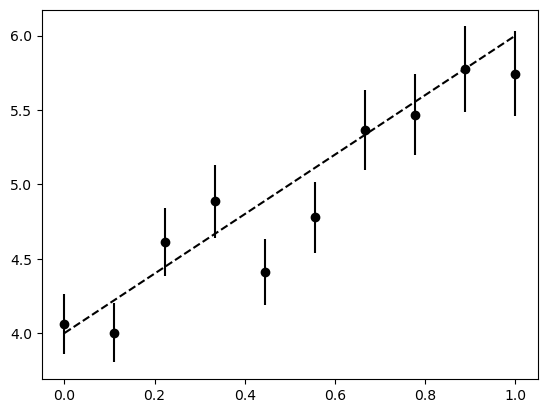

In [14]:
plt.errorbar(
    x_data,
    y_data,
    noise * y_data,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.plot(x_data, y_true, "k--", label="truth")

In [15]:
likelihood = rxmc.likelihood_model.LikelihoodModel()

In [16]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ]
)

In [17]:
def proposal_distribution(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [18]:
sampling_config = rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    prior=prior_distribution,
    initial_proposal_cov=prior_distribution.cov / 100,
)

In [19]:
walker = rxmc.walker.Walker(
    sampling_config,
    evidence,
)

In [20]:
%%time
walker.walk(n_steps=10000, burnin=1000, batch_size=500)

Burn-in batch 1/2 completed, 500 steps.
Burn-in batch 2/2 completed, 500 steps.
Batch: 1/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.388
Batch: 2/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.370
Batch: 3/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.368
Batch: 4/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.358
Batch: 5/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.388
Batch: 6/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.380
Batch: 7/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.396
Batch: 8/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.328
Batch: 9/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.362
Batch: 10/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.366
Batch: 11/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.370
Batch: 12/20 completed, 500 steps. 
  

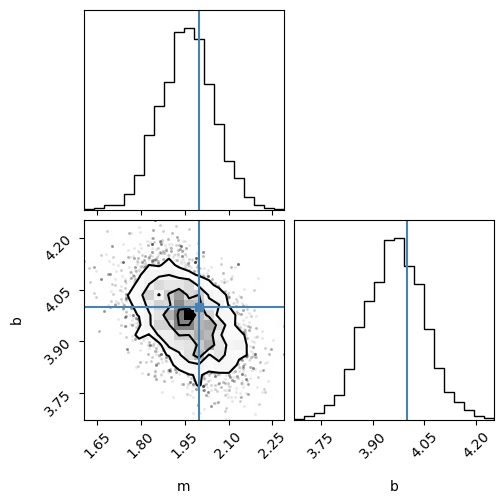

In [21]:
_ = corner.corner(
    walker.model_sampler.chain,
    truths=[true_params["m"], true_params["b"]],
    labels=["m", "b"],
)

In [22]:
def predictive_posterior(
    walker, model, x, x_data, y_exp, y_err, percentile_bounds, added_noise=0.0
):
    n_posterior_samples = walker.model_sampler.chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_sampler.chain[i, :]
        y[i, :] = np.random.normal(loc=model.y(x, *sample), scale=added_noise)

    percentiles = np.percentile(y, percentile_bounds, axis=0)
    return percentiles

## Empirical coverage

In [23]:
spacing = 10
inner_pctls = np.arange(spacing, 100, spacing)
inner_pctls

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [24]:
pb = np.hstack([50 - np.flip(inner_pctls) / 2, 50 + inner_pctls / 2])
pb

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 55., 60., 65., 70.,
       75., 80., 85., 90., 95.])

In [25]:
lower_bounds = np.flip(pb[: inner_pctls.shape[0]])
upper_bounds = pb[inner_pctls.shape[0] :]

In [26]:
for l, u in zip(lower_bounds, upper_bounds):
    print(l, u)

45.0 55.0
40.0 60.0
35.0 65.0
30.0 70.0
25.0 75.0
20.0 80.0
15.0 85.0
10.0 90.0
5.0 95.0


In [27]:
pctls = predictive_posterior(
    walker,
    my_model,
    x_data,
    x_data,
    y_data,
    noise,
    percentile_bounds=pb,
    added_noise=reported_stat_err,
)

In [28]:
pctls_unbroadened = predictive_posterior(
    walker,
    my_model,
    x_data,
    x_data,
    y_data,
    noise,
    percentile_bounds=pb,
    added_noise=0,
)

In [29]:
lower = np.flip(pctls[: inner_pctls.shape[0], :], axis=0)
upper = pctls[inner_pctls.shape[0] :, :]

<ErrorbarContainer object of 3 artists>

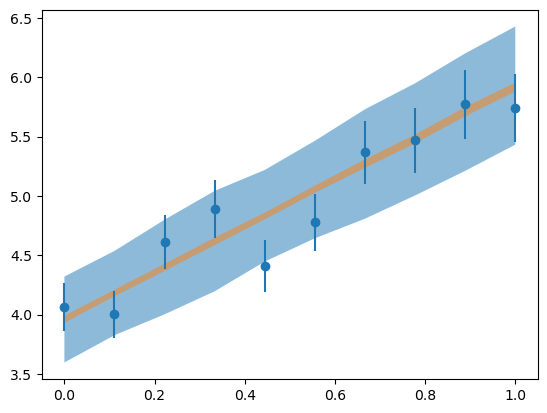

In [30]:
# plt.fill_between(x_data, lower_bounds[-2,:], upper_bounds[-2,:], alpha=0.5)
plt.fill_between(x_data, lower[-1, :], upper[-1, :], alpha=0.5)
plt.fill_between(x_data, lower[0, :], upper[0, :], alpha=0.5)
plt.errorbar(x_data, y_data, reported_stat_err, linestyle="none", marker="o")

In [31]:
lower_l = np.flip(pctls_unbroadened[: inner_pctls.shape[0], :], axis=0)
upper_l = pctls_unbroadened[inner_pctls.shape[0] :, :]

In [32]:
def coverage_counted(y, err, lower, upper):
    coverage_integrated = np.zeros(len(lower))
    for i, (l, u) in enumerate(zip(lower, upper)):
        coverage_integrated[i] = np.mean(np.logical_and(y >= l, y < u))
    return coverage_integrated

In [33]:
def coverage(y, err, lower, upper):
    coverage_integrated = np.zeros(len(lower))
    for i, (l, u) in enumerate(zip(lower, upper)):
        coverage_integrated[i] = np.mean(
            norm.cdf((u - y) / err) - norm.cdf((l - y) / err)
        )
    return coverage_integrated

Text(0.5, 1.0, '$N = 10$')

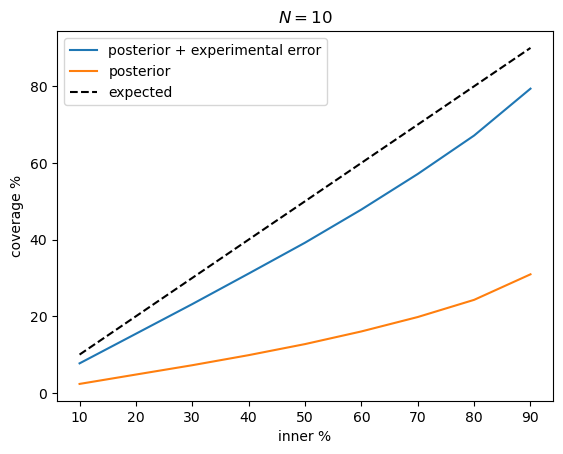

In [34]:
# plt.plot(inner_pctls, coverage_sum * 100, label="sum")

# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)
cov = coverage(y_data, reported_stat_err, lower, upper)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior + experimental error",
)

cov = coverage(y_data, reported_stat_err, lower_l, upper_l)
# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior",
)

plt.plot(inner_pctls, inner_pctls, "k--", label="expected")
plt.legend()
plt.xlabel("inner %")
plt.ylabel("coverage %")
plt.title(f"$N = {N}$")

Text(0.5, 1.0, '$N = 10$')

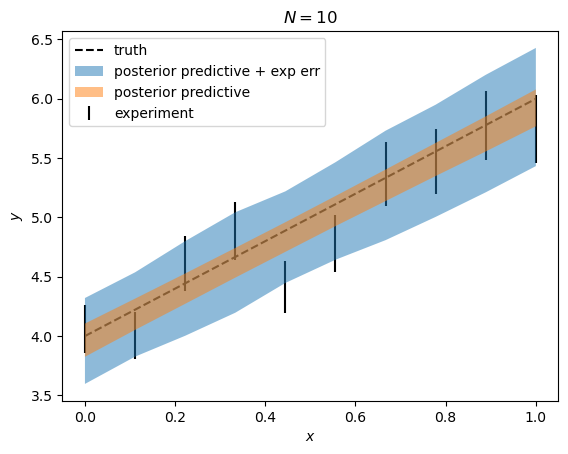

In [35]:
plt.errorbar(
    x_data,
    y_data,
    reported_stat_err,
    color="k",
    marker="none",
    linestyle="none",
    label="experiment",
)


plt.plot(x_data, my_model.y(x_data, *true_params.values()), "k--", label="truth")
p = plt.fill_between(
    x_data,
    lower[-1, :],
    upper[-1, :],
    alpha=0.5,
    zorder=2,
    label=r"posterior predictive + exp err",
)

p = plt.fill_between(
    x_data,
    lower_l[-1, :],
    upper_l[-1, :],
    alpha=0.5,
    zorder=2,
    label=r"posterior predictive",
)



plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.title(f"$N = {N}$")

Text(0.5, 1.0, '$N = 10$')

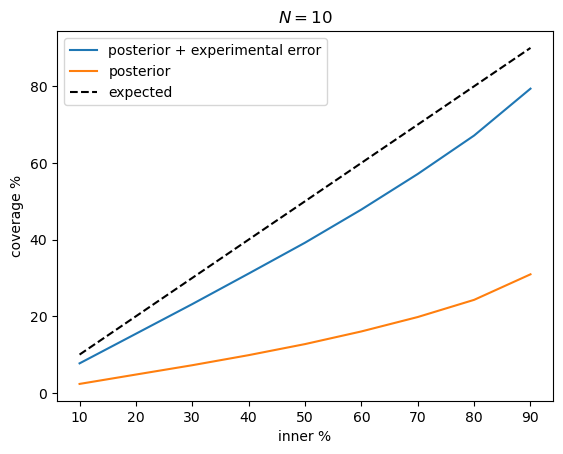

In [36]:
# plt.plot(inner_pctls, coverage_sum * 100, label="sum")

# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)
cov = coverage(y_data, reported_stat_err, lower, upper)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior + experimental error",
)

cov = coverage(y_data, reported_stat_err, lower_l, upper_l)
# cov = coverage_counted(y_data, reported_stat_err, lower_bounds, upper_bounds)

plt.plot(
    inner_pctls,
    cov * 100,
    label="posterior",
)

plt.plot(inner_pctls, inner_pctls, "k--", label="expected")
plt.legend()
plt.xlabel("inner %")
plt.ylabel("coverage %")
plt.title(f"$N = {N}$")